# Remapping using xarray

Lukas wrote a script that leverages the remap function from the easygems package to plot a map, remapping on the fly. The script creates weights with `easygems.remap.compute_weights_delaunay`. This step is somewhat costly (slow). The remapping using these weights with `easygems.remap.apply_weights` is fast. Or rather it is fast when one uses the right kernel. The kernels provided by DKRZ (e.g. `python3/unstable`) are not the right kernel. Thus I had to create my own.

## Creating a kernel

First we specify our environment in a YAML file. The kernel Lukas uses is somewhat based on this [environment file](https://gitlab.dkrz.de/-/snippets/72), but contains many libraries that are not specific to what we do in this notebook. The followins environment turned out to be the most minimal for the script presented in this notebook: 

```yml
name: minimal_remapping
channels:
  - conda-forge
dependencies:
  - python=3.12
  - dask       # necessary when specifying chunking in xarray.open_dataset
  - jupyter    # brings ipykernel utilities
  - matplotlib
  - netCDF4    # needed for writing weights to netcdf
  - numpy
  - pandas
  - xarray
  - pip:
      - easygems # remapping function 
```

To create an environment from this file and [add it as a jupyter kernel](https://docs.dkrz.de/doc/software&services/jupyterhub/kernels.html), we use the these commands:

```
conda env create -f environment.yml
source activate minimal_remapping
python -m ipykernel install --user --name minimal_remapping --display-name="minimal_kernel"
conda deactivate
```

If you grew weary of your kernel, you can get rid of it via:

```
jupyter kernelspec list # just to make sure we got the name right
jupyter kernelspec remove minimal_remapping
conda remove --name minimal_remapping --all
```

## Actual plotting

This is the script Lukas provided. It uses some example data that is a copy of 2D output from the warming simulations inner, high resolution domain.

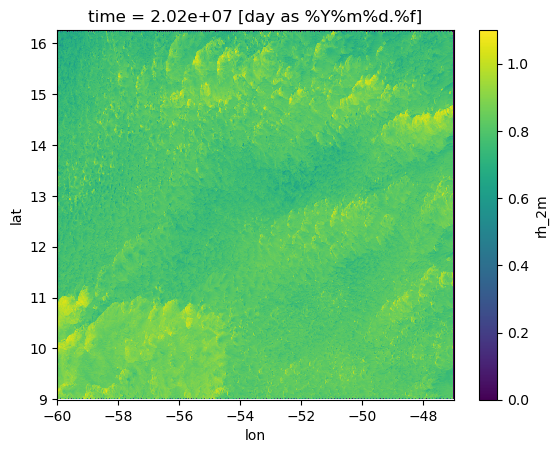

In [1]:
import os
import easygems.remap as egr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

ds = xr.open_dataset("/scratch/m/m300575/DOM_2_surface.nc", chunks={"ncells": -1})
grid = xr.open_dataset("/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/grids/EUREC4A_PR1250m_DOM02.nc")

# Define lat/lon grid
nx, ny = 360 * 4, 180 * 4
lon, lat = np.meshgrid(
    np.linspace(np.min(grid['clon'].values), np.max(grid['clon'].values), nx), 
    np.linspace(np.min(grid['clat'].values), np.max(grid['clat'].values), ny)
)

weights_file = "/scratch/m/m300575/weights_DOM02.nc"
if not os.path.exists(weights_file):
    print('calculating weights')
    weights = egr.compute_weights_delaunay((grid.clon, grid.clat), (lon.ravel(), lat.ravel()))
    weights.to_netcdf(weights_file, mode="w")
weights = xr.open_dataset(weights_file)

# (Lazily) apply remapping function to the whole dataset
ds_remap = xr.apply_ufunc(
    egr.apply_weights,
    ds,
    kwargs=weights,
    input_core_dims=[["ncells"]],
    output_core_dims=[["xy"]],
    output_dtypes=["f4"],
    vectorize=True,
    dask="parallelized",
    dask_gufunc_kwargs={
        "output_sizes": {"xy": lon.size},
    },
).assign(
    xy=pd.MultiIndex.from_product(
        (np.degrees(lat[:, 0]), np.degrees(lon[0, :])), 
        names=("lat", "lon"),
    ),
).unstack("xy")

# Plot 2m temperature
ds_remap.rh_2m.isel(time=2).plot()

## Refactored version

Calculating weights DONE


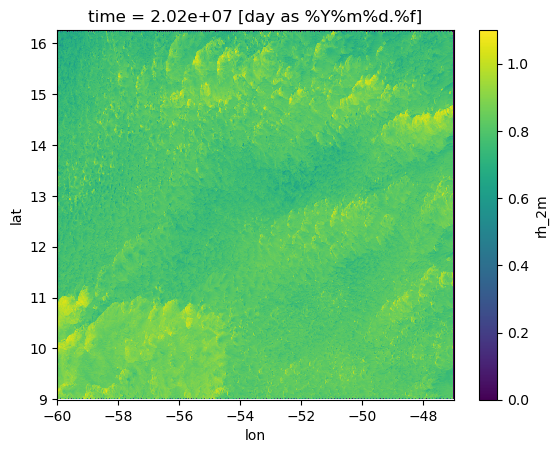

In [2]:
import os
import easygems.remap as egr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

def compute_or_load_weights(grid, weights_file, nx=360*4, ny=180*4, verbose=True):
    """
    Compute weights if not already saved, or load them from a file, along with lon and lat grids.
    """
    lon, lat = np.meshgrid(
        np.linspace(np.min(grid['clon'].values), np.max(grid['clon'].values), nx), 
        np.linspace(np.min(grid['clat'].values), np.max(grid['clat'].values), ny)
    )
    
    if not os.path.exists(weights_file):
        if verbose: print('Calculating weights', end='')
        weights = egr.compute_weights_delaunay((grid.clon, grid.clat), (lon.ravel(), lat.ravel()))
        weights.to_netcdf(weights_file, mode="w")
        if verbose: print(' DONE')
    weights = xr.open_dataset(weights_file)
    return weights, lon, lat

def remap_dataset(ds, weights, lon, lat):
    """
    Apply remapping to the dataset using the provided weights.
    """
    ds_remap = xr.apply_ufunc(
        egr.apply_weights,
        ds,
        kwargs=weights,
        input_core_dims=[["ncells"]],
        output_core_dims=[["xy"]],
        output_dtypes=["f4"],
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs={
            "output_sizes": {"xy": lon.size},
        },
    ).assign(
        xy=pd.MultiIndex.from_product(
            (np.degrees(lat[:, 0]), np.degrees(lon[0, :])), 
            names=("lat", "lon"),
        ),
    ).unstack("xy")
    return ds_remap

data_file    = "/scratch/m/m300575/DOM_2_surface.nc"
grid_file    = "/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/grids/EUREC4A_PR1250m_DOM02.nc"
weights_file = "/scratch/m/m300872/weights_DOM02_new2.nc"

ds = xr.open_dataset(data_file, chunks={"ncells": -1})
grid = xr.open_dataset(grid_file)

weights, lon, lat = compute_or_load_weights(grid, weights_file)
ds_remap = remap_dataset(ds, weights, lon, lat)

ds_remap['rh_2m'].isel(time=2).plot()

In [ ]:
import os
import easygems.remap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

def timestamp(date_time=None):
    """
    Returns the date in YYYYMMDD format for the given datetime object.
    If no datetime object is provided, it defaults to the current date.

    Args:
        date_time (datetime, optional): The datetime object to format. Defaults to None.

    Returns:
        str: The date formatted as YYYYMMDD.
    """
    if date_time is None:
        date_time = datetime.now()
    return date_time.strftime('%Y%m%d')
    
def _create_lat_lon_grid(grid, nx=None, ny=None, resolution=None, varnames={'latitude': 'lat', 'longitude': 'lon'}):
    """
    Creates a latitude and longitude grid based on the provided grid and resolution.

    Args:
        grid (xarray.Dataset): The input dataset containing latitude and longitude variables.
        nx (int, optional): Number of points in the x-direction. Defaults to None.
        ny (int, optional): Number of points in the y-direction. Defaults to None.
        resolution (float, optional): Resolution given as a fraction of a degree. Defaults to None.
        varnames (dict, optional): Dictionary mapping 'latitude' and 'longitude' to their variable names in the dataset. Defaults to {'latitude': 'lat', 'longitude': 'lon'}.

    Returns:
        tuple: A tuple containing the longitude and latitude grids.
    """
    lon_min, lon_max = np.min(grid[varnames['longitude']].values), np.max(grid[varnames['longitude']].values)
    lat_min, lat_max = np.min(grid[varnames['latitude']].values), np.max(grid[varnames['latitude']].values)
    
    if resolution is not None:
        nx = int((lon_max - lon_min) / resolution)
        ny = int((lat_max - lat_min) / resolution)

    lon, lat = np.meshgrid(
        np.linspace(lon_min, lon_max, nx), 
        np.linspace(lat_min, lat_max, ny)
    )
    return lon, lat
    
def _compute_remap_weights(grid, lon, lat, 
                      weights_file=None, 
                      varnames={'latitude': 'lat', 'longitude': 'lon'}):
    """
    Computes remapping weights for the given grid and saves them to a file.

    Args:
        grid (xarray.Dataset): The input dataset containing latitude and longitude variables.
        lon (numpy.ndarray): The longitude grid.
        lat (numpy.ndarray): The latitude grid.
        weights_file (str, optional): Path to the file where weights will be saved. Defaults to None.
        varnames (dict, optional): Dictionary mapping 'latitude' and 'longitude' to their variable names in the dataset. Defaults to {'latitude': 'lat', 'longitude': 'lon'}.

    Returns:
        xarray.Dataset: The dataset containing the remapping weights.
    """
    if weights_file ==  None:
        weights_file = f"/scratch/m/m300872/weight_files/weights_{lon.shape[0]}x{lon.shape[1]}_{timestamp()}.nc"
    
    if not os.path.exists(weights_file):
        print(f'calculating weights, saving to {os.path.basename(weights_file)}')
        weights = easygems.remap.compute_weights_delaunay((grid.lon, grid.lat), (lon.ravel(), lat.ravel()))
        weights.to_netcdf(weights_file, mode="w")
    return xr.open_dataset(weights_file)

def _remap_delaunay(ds, weights, lon, lat, varnames={'cell': 'cell'}):
    """
    Remaps the dataset using Delaunay Triangulation.

    Args:
        ds (xarray.Dataset): The input dataset to be remapped.
        weights (xarray.Dataset): The dataset containing remapping weights.
        lon (numpy.ndarray): The longitude grid.
        lat (numpy.ndarray): The latitude grid.
        varnames (dict, optional): Dictionary mapping 'cell' to its variable name in the dataset. Defaults to {'cell': 'cell'}.

    Returns:
        xarray.Dataset: The remapped dataset.
    """
    ds_remap = xr.apply_ufunc(
        easygems.remap.apply_weights,
        ds,
        kwargs=weights,
        input_core_dims=[[varnames["cell"]]],
        output_core_dims=[["xy"]],
        output_dtypes=["f4"],
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs={
            "output_sizes": {"xy": lon.size},
        },
    ).assign(
        xy=pd.MultiIndex.from_product(
            (np.degrees(lat[:, 0]), np.degrees(lon[0, :])), 
            names=("lat", "lon"),
        ),
    ).unstack("xy")
    return ds_remap

def regrid_latlon(ds, resolution=0.5):
    """
    Regrids the dataset to a new latitude-longitude grid with the specified resolution in degree. 
    
    Makes use of the easygems package.

    Args:
        ds (xarray.Dataset): The input dataset to be regridded.
        resolution (float, optional): Resolution given as a fraction of a degree. Defaults to 0.5.

    Returns:
        xarray.Dataset: The regridded dataset.
    """
    lon, lat = _create_lat_lon_grid(ds, resolution=resolution)
    weights = _compute_remap_weights(ds, lon, lat)
    ds_remap = _remap_delaunay(ds, weights, lon, lat)
    return ds_remap
    
def load_datasets(data_path):
    ds = xr.open_dataset(data_path, chunks={"ncells": -1})
    ds = pp.clean_surface_data(ds)
    ds = pp.add_grid(ds)
    return ds

def plot_temperature(ds_remap, time_index=2):
    ds_remap.rh_2m.isel(time=time_index).plot()
    plt.show()

data_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_surface_20200116T063000Z.nc'
ds = load_datasets(data_path)
ds = regrid(ds, 1)
plot_temperature(ds)

with the above functions moved to `postprocessing`.

In [ ]:
import importlib
importlib.reload(pp)

def load_datasets(data_path):
    ds = xr.open_dataset(data_path, chunks={"ncells": -1})
    ds = pp.clean_surface_data(ds)
    ds = pp.add_grid(ds)
    return ds

def plot_temperature(ds_remap, time_index=2):
    ds_remap.rh_2m.isel(time=time_index).plot()
    plt.show()

data_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05/moist_adiabatic_05_DOM01_surface_20200116T063000Z.nc'
ds = load_datasets(data_path)
ds = pp.regrid_latlon(ds, 1)
plot_temperature(ds)